# Comprehensive Tutorial on GPyTorch

This notebook introduces **GPyTorch** for Gaussian process (GP) modeling in PyTorch. We cover:

- Generating synthetic data
- Defining an exact GP model with various kernels (RBF, Matern, Periodic, etc.)
- Maximizing the marginal likelihood (i.e., hyperparameter tuning)
- Making predictions with uncertainty quantification

Let's get started!

## 1. Setup and Imports

We first import the necessary libraries. Note that you need to have both **torch** and **gpytorch** installed.

In [1]:
import math
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Generating Synthetic Data

We generate a simple 1D dataset from a noisy sine function. This data will be used for GP regression.

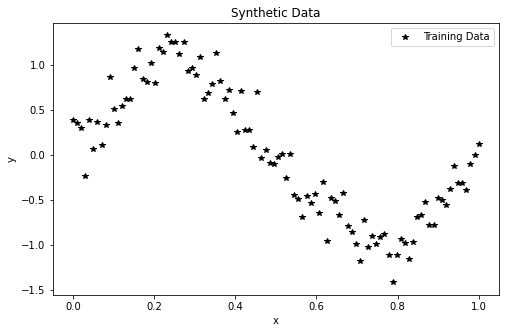

In [2]:
# Generate training data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

# For prediction, we use a denser grid
test_x = torch.linspace(0, 1, 200)

# Plot the training data
plt.figure(figsize=(8, 5))
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data')
plt.legend()
plt.show()

## 3. Defining the GP Model

We define an exact GP model by subclassing `gpytorch.models.ExactGP`. The model uses a constant mean function and a covariance (kernel) module. 

In the constructor, we allow the user to choose the kernel type (e.g., **RBF**, **Matern**, or **Periodic**). 

The marginal log likelihood will later be maximized to tune the hyperparameters.

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel_type="RBF"):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        
        # Mean module
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Choose kernel type
        if kernel_type == "RBF":
            covar_module = gpytorch.kernels.RBFKernel()
        elif kernel_type == "Matern":
            covar_module = gpytorch.kernels.MaternKernel(nu=2.5)
        elif kernel_type == "Periodic":
            covar_module = gpytorch.kernels.PeriodicKernel()
        else:
            print("Kernel type not recognized. Defaulting to RBF.")
            covar_module = gpytorch.kernels.RBFKernel()
        
        # Wrap the kernel in a ScaleKernel
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## 4. Training the GP Model (Maximizing the Marginal Likelihood)

We now set up the GP model for training. The steps include:

1. Initializing a **Gaussian Likelihood** and the **ExactGPModel** with a chosen kernel type.
2. Defining the **marginal log likelihood (mll)** as the objective.
3. Running a training loop to maximize the mll (i.e., minimize its negative) via gradient descent.

In this example, we use the **RBF** kernel.

In [4]:
# Use a Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Initialize the GP model with the RBF kernel
model = ExactGPModel(train_x, train_y, likelihood, kernel_type="RBF")

# Set the model in training mode
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam([ 
    {'params': model.parameters()},  # Includes kernel hyperparameters
], lr=0.1)

# Marginal Log Likelihood (MLL)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
loss_history = []

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    loss_history.append(loss.item())
    if (i+1) % 10 == 0:
        print(f'Iteration {i+1}/{training_iterations} - Loss: {loss.item():.3f}')
    optimizer.step()

Iteration 10/100 - Loss: 0.548
Iteration 20/100 - Loss: 0.194
Iteration 30/100 - Loss: -0.057
Iteration 40/100 - Loss: -0.085
Iteration 50/100 - Loss: -0.087
Iteration 60/100 - Loss: -0.098
Iteration 70/100 - Loss: -0.097
Iteration 80/100 - Loss: -0.098
Iteration 90/100 - Loss: -0.098
Iteration 100/100 - Loss: -0.098


## 5. Making Predictions and Visualizing the Results

After training, we switch the model to evaluation mode and make predictions on a test grid. We then plot the predictive mean and 95% confidence intervals.

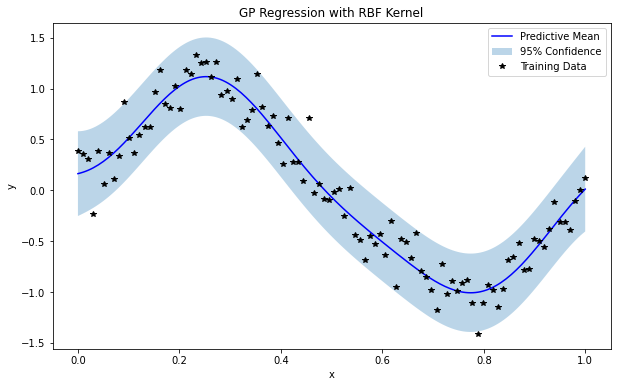

In [5]:
# Set into evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Get predictive mean and confidence intervals
mean = observed_pred.mean.numpy()
lower, upper = observed_pred.confidence_region()
lower = lower.numpy()
upper = upper.numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_x.numpy(), mean, 'b', label='Predictive Mean')
plt.fill_between(test_x.numpy(), lower, upper, alpha=0.3, label='95% Confidence')
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP Regression with RBF Kernel')
plt.legend()
plt.show()

## 6. Using Various Kernels

GPyTorch makes it simple to swap kernels. In the `ExactGPModel` above, we allow for choosing between different kernels. 

Below is an example of training a GP model using the **Matern** kernel. You can change the `kernel_type` parameter to explore other kernels (such as "Periodic").

[10/100] Matern Loss: 0.549
[20/100] Matern Loss: 0.201
[30/100] Matern Loss: -0.047
[40/100] Matern Loss: -0.086
[50/100] Matern Loss: -0.081
[60/100] Matern Loss: -0.094
[70/100] Matern Loss: -0.093
[80/100] Matern Loss: -0.094
[90/100] Matern Loss: -0.094
[100/100] Matern Loss: -0.094


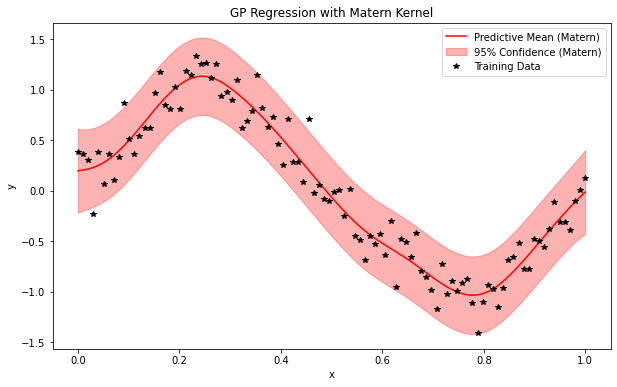

In [6]:
# Reinitialize likelihood and model with the Matern kernel
likelihood_matern = gpytorch.likelihoods.GaussianLikelihood()
model_matern = ExactGPModel(train_x, train_y, likelihood_matern, kernel_type="Matern")

model_matern.train()
likelihood_matern.train()

optimizer_matern = torch.optim.Adam(model_matern.parameters(), lr=0.1)
mll_matern = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_matern, model_matern)

training_iterations = 100
loss_history_matern = []

for i in range(training_iterations):
    optimizer_matern.zero_grad()
    output = model_matern(train_x)
    loss = -mll_matern(output, train_y)
    loss.backward()
    loss_history_matern.append(loss.item())
    if (i+1) % 10 == 0:
        print(f'[{i+1}/{training_iterations}] Matern Loss: {loss.item():.3f}')
    optimizer_matern.step()

# Evaluate the model
model_matern.eval()
likelihood_matern.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_matern = likelihood_matern(model_matern(test_x))

mean_matern = observed_pred_matern.mean.numpy()
lower_matern, upper_matern = observed_pred_matern.confidence_region()
lower_matern = lower_matern.numpy()
upper_matern = upper_matern.numpy()

# Plot predictions with the Matern kernel
plt.figure(figsize=(10, 6))
plt.plot(test_x.numpy(), mean_matern, 'r', label='Predictive Mean (Matern)')
plt.fill_between(test_x.numpy(), lower_matern, upper_matern, color='r', alpha=0.3, label='95% Confidence (Matern)')
plt.plot(train_x.numpy(), train_y.numpy(), 'k*', label='Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP Regression with Matern Kernel')
plt.legend()
plt.show()

## 7. Conclusion

In this notebook we:

- Introduced GPyTorch and generated synthetic data for GP regression.
- Defined an exact GP model that allows you to choose among various kernels.
- Maximized the marginal likelihood (i.e., trained the GP) to tune hyperparameters.
  
Feel free to experiment with different kernel choices and training iterations to better understand how the GP model adapts to data.

Happy modeling with GPyTorch!